# CNN model building for the CBIS-DDSM

## EDA

### Data Preprocessing
In the extraction of the subset of data, from the CBIS-DDSM dataset, cleaning and preparing the dicom files and meta data was completed. Currently, the dataset used for the CNN model building includes:

* 125 patients
* 454 dicom files
* Each patient has 2 or 4 associating dicom files
* A csv with 454 records (information on each dicom file)
* The csv features include: Patient ID, pathology label (malignant = 1, benign = 0) and dicom path in subset folder
* Number of malignant and benign cases according to the original mass_case_descriptors_train_set.csv are equal. Of 454 dicom files there is a 50/50 split betwen malignasnt and benign
* All loaded to google drive and unzipped in collab under CBIS-DDSM_Subset folder

Due to computational constraints, the subset of the dataset is much smaller than what is preferred to train a CNN. Ideally a stronger GPU and the full mass_training dataset should be used to train the CNN, to achieve the optimal results. A CNN model used for cancer prediction in breast cancer should include as many varying samples as possible. This improves the identification of the tumours and allows the model to leanr features of the tumors effectively. This depth in features enables the ideal model to better adapt to new CC or MLO scans, to pick up malignant or benign tumours.

#### Installing package for dicom reader

In [ ]:
!pip install dicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.3/766.3 kB 9.4 MB/s eta 0:00:00


In [ ]:
!pip install pydicom

#### Importing libraries

In [ ]:
import pandas as pd
import os
#for reading dicom images ---> https://www.geeksforgeeks.org/python/view-dicom-images-using-pydicom-and-matplotlib/
import pydicom
import pydicom.data
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models

###  Mounting to personal drive
A subset of the CBIS-DDSM was extracted using a separate project. This dataset originated from the mass_case_description_train_set.csv subset of the CBIS-DDSM. The dataset was cleaned and the following sampling was implemented.

### Sampling Strategy
* A purposive sample of 454 dicom images (125 patients) was extractd from the CBIS-DDSM mass train dataset.
* Includes cases with complete images and valid pathology results.
* Exclusion of corrupted, missing dicoms.
This subset was chosen for being computationally managable yet still representative of the dataset.

The imbalance was handled through sampling an equal amount of benign and malignant cases. There were initially two benign case classes, however these were combined to decrease risk of overfitting.

It is important to note that there was no primary data collection and all data was taken from the https://www.cancerimagingarchive.net/collection/cbis-ddsm/.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Loading the data

In [ ]:
data_dir = '/content/drive/MyDrive/CBIS-DDSM_Subset/Mass_training'

Unzipping folder to access it

In [ ]:
!unzip -q "/content/drive/MyDrive/CBIS-DDSM_Subset.zip" -d "/content/CBIS-DDSM_Subset"

Verifying if unzip was successful.

In [ ]:
!ls "/content/CBIS-DDSM_Subset/CBIS-DDSM_Subset"


Mass-Training_P_00023_RIGHT_CC	   Mass-Training_P_00870_LEFT_MLO
Mass-Training_P_00023_RIGHT_CC_1   Mass-Training_P_00870_LEFT_MLO_1
Mass-Training_P_00023_RIGHT_MLO    Mass-Training_P_00881_LEFT_CC
Mass-Training_P_00023_RIGHT_MLO_1  Mass-Training_P_00881_LEFT_CC_1
Mass-Training_P_00068_RIGHT_CC	   Mass-Training_P_00881_LEFT_MLO
Mass-Training_P_00068_RIGHT_CC_1   Mass-Training_P_00881_LEFT_MLO_1
Mass-Training_P_00068_RIGHT_MLO    Mass-Training_P_00911_LEFT_CC
Mass-Training_P_00068_RIGHT_MLO_1  Mass-Training_P_00911_LEFT_CC_1
Mass-Training_P_00074_LEFT_MLO	   Mass-Training_P_00972_LEFT_CC
Mass-Training_P_00074_LEFT_MLO_1   Mass-Training_P_00972_LEFT_CC_1
Mass-Training_P_00074_RIGHT_CC	   Mass-Training_P_00972_LEFT_MLO
Mass-Training_P_00074_RIGHT_CC_1   Mass-Training_P_00972_LEFT_MLO_1
Mass-Training_P_00074_RIGHT_MLO    Mass-Training_P_00990_RIGHT_CC
Mass-Training_P_00074_RIGHT_MLO_1  Mass-Training_P_00990_RIGHT_CC_1
Mass-Training_P_00080_RIGHT_CC	   Mass-Training_P_00990_RIGHT_MLO
Mass-T

Readjusting data directory path to were the mass training data is located. This enables the access to the folders which hold the necessary dicoms.

In [ ]:
data_dir = '/content/CBIS-DDSM_Subset/CBIS-DDSM_Subset'

In [ ]:
print(os.listdir(data_dir)[:5])

['Mass-Training_P_01619_LEFT_MLO_1', 'Mass-Training_P_01543_RIGHT_CC', 'Mass-Training_P_00435_RIGHT_MLO', 'Mass-Training_P_00675_LEFT_MLO', 'Mass-Training_P_01201_LEFT_MLO']


In [ ]:
csv_path = '/content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/metadata_subset.csv'

#### Basic Visualisations
Just to view the basic information on the csv (meta data)

In [ ]:
df = pd.read_csv(csv_path)
print(df.head())
print(df['label'].value_counts())

  patient_id  label                                        folder_path
0    P_01803      1  D:\RPDA8412 Breast Cancer Analysis\CBIS-DDSM_S...
1    P_01803      1  D:\RPDA8412 Breast Cancer Analysis\CBIS-DDSM_S...
2    P_01803      1  D:\RPDA8412 Breast Cancer Analysis\CBIS-DDSM_S...
3    P_01803      1  D:\RPDA8412 Breast Cancer Analysis\CBIS-DDSM_S...
4    P_00370      1  D:\RPDA8412 Breast Cancer Analysis\CBIS-DDSM_S...
label
0    238
1    216
Name: count, dtype: int64


> Bar plot to visualise and confirm 50/50 split between two pathology results. Important to remember that there were two benign groups which are now combined to prevent overfitting. These groups were benign and benign_without_callback.

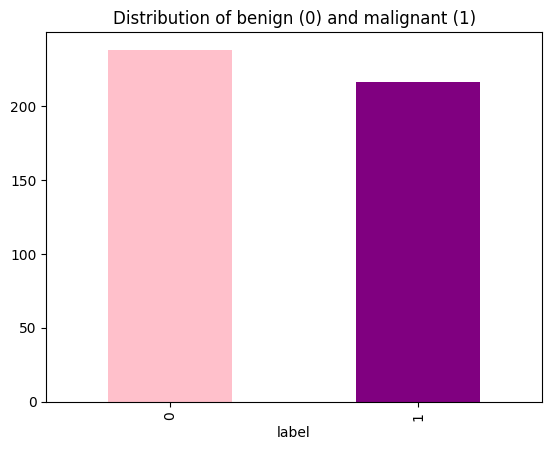

In [ ]:
df['label'].value_counts().plot(kind='bar', color=['pink', 'purple'])
plt.title("Distribution of benign (0) and malignant (1)")
plt.show()

There is a slight difference in distribution of cases according to their pathology. Benign has a bit more which is confirmed by the previous count of the files. Benign has 238 files whilst malignant has 216.

This discrepency is probably from the structure of the dataset. Although the patients were evenly sampled between benign and malignant categories (same num from each group), the number of image files per patient caries. Some patients have multiple associated dicom files whilst others have fewer. For example some patients might have btoh CC and ML views for each breast. This means when all images associated with the selected patients were included, benign cases contributed more than malignant. So patients were split evenly but cases or files will result in a discrepency.

>Picking a dicom file to show, this is to confirm the path structure and loading of files from drive

It came up with a small error on path files not found due to the unzip changing the path files.

>D:\RPDA8412 Breast Cancer Analysis\CBIS-DDSM_Subset\Mass-Training_P_01803_RIGHT_CC
ls: cannot access 'D:\RPDA8412 Breast Cancer Analysis\CBIS-DDSM_Subset\Mass-Training_P_01803_RIGHT_CC': No such file or directory
D:\RPDA8412 Breast Cancer Analysis\CBIS-DDSM_Subset\Mass-Training_P_01803_RIGHT_CC
ls: cannot access 'D:\RPDA8412 Breast Cancer Analysis\CBIS-DDSM_Subset\Mass-Training_P_01803_RIGHT_CC': No such file or directory


Will fix this error through updating the files to the collab one now.

In [ ]:
df['folder_path'] = df['folder_path'].str.replace(
    r'^D:\\RPDA8412 Breast Cancer Analysis\\CBIS-DDSM_Subset',
    '/content/CBIS-DDSM_Subset/CBIS-DDSM_Subset',
    regex=True
)
print(df['folder_path'].head())

0    /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset\Mas...
1    /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset\Mas...
2    /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset\Mas...
3    /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset\Mas...
4    /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset\Mas...
Name: folder_path, dtype: object


In [ ]:
df['folder_path'] = df['folder_path'].str.replace('\\', '/', regex=False)
print(df['folder_path'].head())

sample_folder = df['folder_path'].iloc[0]
!ls "$sample_folder"


0    /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/Mas...
1    /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/Mas...
2    /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/Mas...
3    /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/Mas...
4    /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/Mas...
Name: folder_path, dtype: object
07-20-2016-DDSM-NA-28334


Sample folder: /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/Mass-Training_P_01803_RIGHT_CC
Found dicom file: /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/Mass-Training_P_01803_RIGHT_CC/07-20-2016-DDSM-NA-28334/1.000000-full mammogram images-50055/1-1.dcm


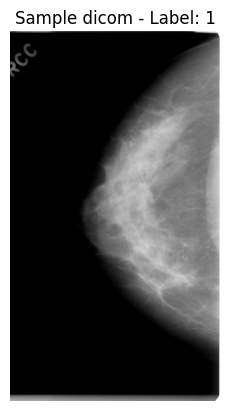

In [ ]:
#taking the first folder
sample_folder = df['folder_path'].iloc[0]
print("Sample folder:", sample_folder)

dcm_found = False
for root, _, files in os.walk(sample_folder):
    for f in files:
        if f.endswith('.dcm'):
            path = os.path.join(root, f)
            print("Found dicom file:", path)

            try:
                dcm = pydicom.dcmread(path)
                img = dcm.pixel_array
                plt.imshow(img, cmap='grey')
                plt.title(f"Sample dicom - Label: {df['label'].iloc[0]}")
                plt.axis('off')
                plt.show()
                dcm_found = True
                break
            except Exception as e:
                print("Error reading dicom:", e)
    if dcm_found:
        break

if not dcm_found:
    print("No dicom file found in the folder or subfolders.")

It works now, the image displayed is the dicom file with pathology label 1, meaning it is malignant. The following is code to display another set of dicoms. Displaying another malignant labelled dicom and two benign labelled.

Sample folder: /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/Mass-Training_P_01799_LEFT_CC
Found dicom file: /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/Mass-Training_P_01799_LEFT_CC/07-20-2016-DDSM-NA-60581/1.000000-full mammogram images-75503/1-1.dcm


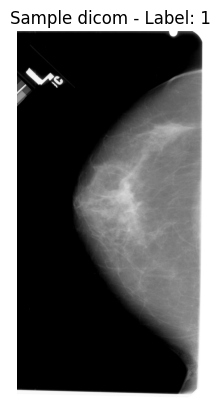

In [ ]:
#taking another malignant case
sample_folder = df['folder_path'].iloc[210]
print("Sample folder:", sample_folder)

dcm_found = False
for root, _, files in os.walk(sample_folder):
    for f in files:
        if f.endswith('.dcm'):
            path = os.path.join(root, f)
            print("Found dicom file:", path)

            try:
                dcm = pydicom.dcmread(path)
                img = dcm.pixel_array
                plt.imshow(img, cmap='grey')
                plt.title(f"Sample dicom - Label: {df['label'].iloc[210]}")
                plt.axis('off')
                plt.show()
                dcm_found = True
                break
            except Exception as e:
                print("Error reading dicom:", e)
    if dcm_found:
        break

if not dcm_found:
    print("No dicom file found in the folder or subfolders.")

Sample folder: /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/Mass-Training_P_01877_LEFT_MLO
Found dicom file: /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/Mass-Training_P_01877_LEFT_MLO/07-20-2016-DDSM-NA-75502/1.000000-full mammogram images-09736/1-1.dcm


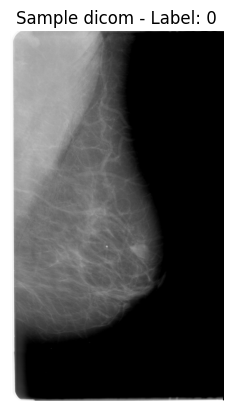

In [ ]:
#taking another benign one
sample_folder = df['folder_path'].iloc[286]
print("Sample folder:", sample_folder)

dcm_found = False
for root, _, files in os.walk(sample_folder):
    for f in files:
        if f.endswith('.dcm'):
            path = os.path.join(root, f)
            print("Found dicom file:", path)

            try:
                dcm = pydicom.dcmread(path)
                img = dcm.pixel_array
                plt.imshow(img, cmap='grey')
                plt.title(f"Sample dicom - Label: {df['label'].iloc[286]}")
                plt.axis('off')
                plt.show()
                dcm_found = True
                break
            except Exception as e:
                print("Error reading dicom:", e)
    if dcm_found:
        break

if not dcm_found:
    print("No dicom file found in the folder or subfolders.")

Sample folder: /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/Mass-Training_P_01866_RIGHT_MLO
Found dicom file: /content/CBIS-DDSM_Subset/CBIS-DDSM_Subset/Mass-Training_P_01866_RIGHT_MLO/07-20-2016-DDSM-NA-68631/1.000000-full mammogram images-91261/1-1.dcm


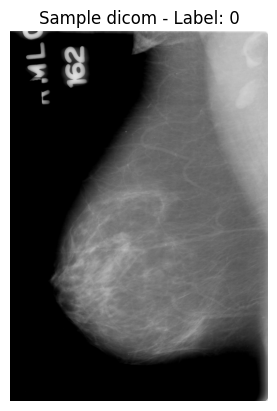

In [ ]:
#taking another benign one
sample_folder = df['folder_path'].iloc[300]
print("Sample folder:", sample_folder)

dcm_found = False
for root, _, files in os.walk(sample_folder):
    for f in files:
        if f.endswith('.dcm'):
            path = os.path.join(root, f)
            print("Found dicom file:", path)

            try:
                dcm = pydicom.dcmread(path)
                img = dcm.pixel_array
                plt.imshow(img, cmap='grey')
                plt.title(f"Sample dicom - Label: {df['label'].iloc[300]}")
                plt.axis('off')
                plt.show()
                dcm_found = True
                break
            except Exception as e:
                print("Error reading dicom:", e)
    if dcm_found:
        break

if not dcm_found:
    print("No dicom file found in the folder or subfolders.")

Even with an untrained human eye, the pathology labels can highlight the differences between the dicoms. The malignant scans show a brighter area in the breast tissue. Based on the scan below from a breast cancer scan article by Desai (n/d), we can see a link in the cancerous tissue. It can be assumed that these are the links that this CNN model will be learning to highlight.

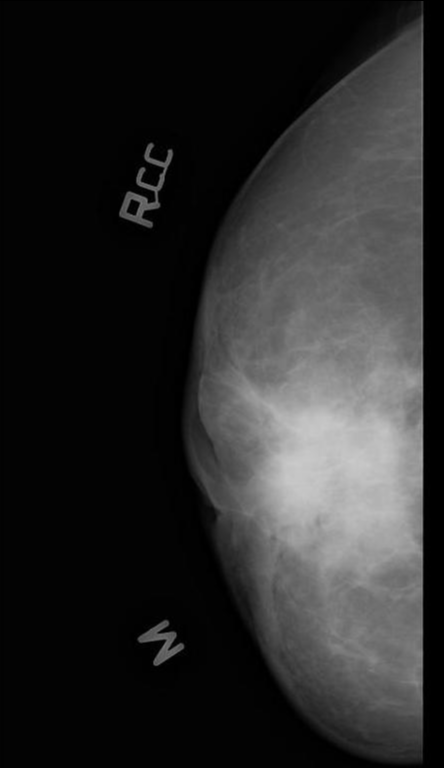

Normalising dicom sizes.

In [ ]:
IMG_SIZE = 224

def load_dicom(folder_path, size=IMG_SIZE):
    for root, _, files in os.walk(folder_path):
        for f in files:
            if f.lower().endswith('.dcm'):
                try:
                    ds = pydicom.dcmread(os.path.join(root, f))
                    img = ds.pixel_array.astype('float32')
                    #[0,1] normalised
                    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
                    img = cv2.resize(img, (size, size))
                    return img
                except Exception as e:
                    print(f"Skipping {f} because an error: {e} occured")
    return None

loading all dicom imgs and labels

In [ ]:
images, labels = [], []

for _, row in df.iterrows():
    img = load_dicom(row['folder_path'])
    if img is not None:
        images.append(img)
        labels.append(row['label'])
    else:
        print(f"No dicom found for folder: {row['folder_path']}")

converting to arrays of images and associating labels

In [ ]:
X = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(labels)

print("Dataset loaded")
print("Shape of X:", X.shape)
unique, counts = np.unique(y, return_counts=True)
print("Label distribution:", dict(zip(unique, counts)))

Dataset loaded
Shape of X: (454, 224, 224, 1)
Label distribution: {np.int64(0): np.int64(238), np.int64(1): np.int64(216)}


Reloading to check image size. The original dicom files are not change, only the in memory files are changed for this runtime.

Resized shape: (224, 224)


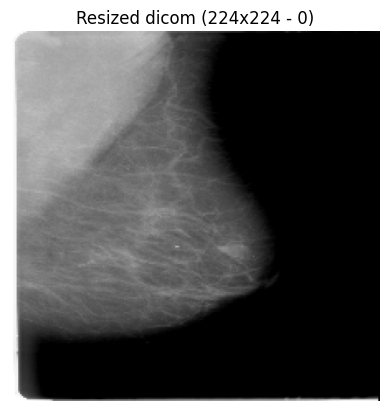

In [ ]:
img_resized = load_dicom(df['folder_path'].iloc[286])
print("Resized shape:", img_resized.shape)

plt.imshow(img_resized, cmap='gray')
plt.title(f"Resized dicom (224x224 - {df['label'].iloc[300]})")
plt.axis('off')
plt.show()

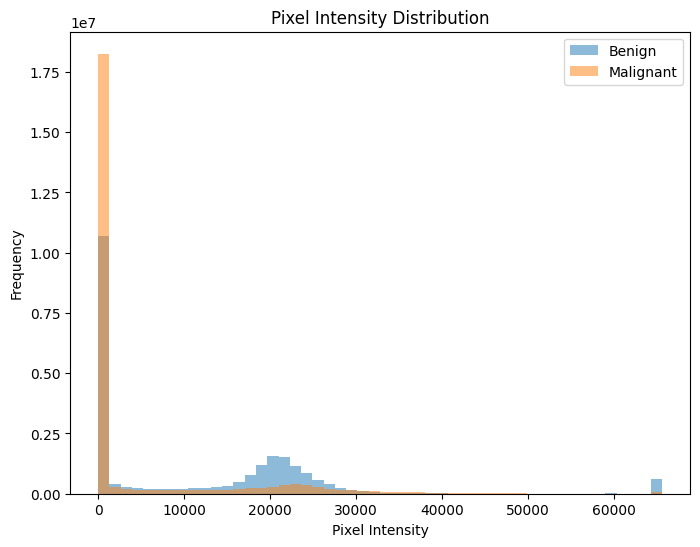

In [ ]:
import random

#randomly pick one benign and malignant from dataframe
benign_idx = df[df['label'] == 0].sample(1).index[0]
malignant_idx = df[df['label'] == 1].sample(1).index[0]

benign_path = df.loc[benign_idx, 'folder_path']
malignant_path = df.loc[malignant_idx, 'folder_path']

#retrieving file from nested folders
def get_first_dicom_file(folder):
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".dcm"):
                return os.path.join(root, file)
    return None

benign_file = get_first_dicom_file(benign_path)
malignant_file = get_first_dicom_file(malignant_path)

#read dicom imgs and flatten the pixel arrays
benign_img = pydicom.dcmread(benign_file).pixel_array.flatten()
malignant_img = pydicom.dcmread(malignant_file).pixel_array.flatten()

plt.figure(figsize=(8,6))
plt.hist(benign_img, bins=50, alpha=0.5, label='Benign')
plt.hist(malignant_img, bins=50, alpha=0.5, label='Malignant')
plt.legend()
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

## Training dataset

Splitting train and test

In order to effectively retain the balance in the dataset, the train-test split needs to be similar to how the subset was extracted.
* The records will need to be grouped by patient and label.
* Splitting of the dataset into train and test will happen at the patient level first.
* Stratify is used to retain the balance with the two classes: benign and malignant.



In [ ]:
patient_labels = df.groupby('patient_id')['label'].first()

train_patients, test_patients = train_test_split(
    patient_labels.index,
    test_size=0.2,
    stratify=patient_labels,
    random_state=42
)

train_df = df[df['patient_id'].isin(train_patients)].reset_index(drop=True)
test_df  = df[df['patient_id'].isin(test_patients)].reset_index(drop=True)

print(f"Train patients: {len(train_patients)} | Samples: {len(train_df)}")
print(f"Test patients:  {len(test_patients)} | Samples: {len(test_df)}")

Train patients: 97 | Samples: 350
Test patients:  25 | Samples: 104


In [ ]:
print("Train:", np.unique(y_train, return_counts=True))
print("Test:", np.unique(y_test, return_counts=True))

The dataset was split at patient level, with all scans pertaining to the patient staying within the same set. Out of 125 patients, 97 patients were allocated to the training set which are 350 scans. In the training set, there are 25 patients and 104 scans.

Using dicom loading function defined earlier to retrieve all dicom files related to train paitents and populate a new array for that data.

In [ ]:
train_images, train_labels = [], []
for _, row in train_df.iterrows():
    img = load_dicom(row['folder_path'])
    if img is not None:
        train_images.append(img)
        train_labels.append(row['label'])
    else:
        print(f"No dicom found for folder: {row['folder_path']}")

X_train = np.array(train_images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(train_labels)
print("Train shape:", X_train.shape)
print("Train label distribution:", dict(zip(*np.unique(y_train, return_counts=True))))

Train shape: (350, 224, 224, 1)
Train label distribution: {np.int64(0): np.int64(178), np.int64(1): np.int64(172)}


Using dicom loading function defined earlier to retrieve all dicom files related to test paitents and populate a new array for that data.

In [ ]:
test_images, test_labels = [], []
for _, row in test_df.iterrows():
    img = load_dicom(row['folder_path'])
    if img is not None:
        test_images.append(img)
        test_labels.append(row['label'])
    else:
        print(f"No dicom found for folder: {row['folder_path']}")

X_test = np.array(test_images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(test_labels)
print("Test shape:", X_test.shape)
print("Test label distribution:", dict(zip(*np.unique(y_test, return_counts=True))))

Test shape: (104, 224, 224, 1)
Test label distribution: {np.int64(0): np.int64(60), np.int64(1): np.int64(44)}


Data enhancement to increase training diversity and decrease overfitting. Using Keras image data generator, implementation covered by Study Machine Learning (n/d)

Study Machine Learning. n/d. Keras ImageDataGenerator. n/d. [Online]. Available at: https://studymachinelearning.com/keras-imagedatagenerator/. [Accessed on 24 October 2025].

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#creating the generator for train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
#rescaling the data using imagedatagen
test_datagen = ImageDataGenerator(rescale=1./255)
#applying the generators to each set: train and test
train_gen = train_datagen.flow(X_train, y_train, batch_size=16, shuffle=True)
test_gen  = test_datagen.flow(X_test, y_test, batch_size=16, shuffle=False)

### Training with model architecture

The specified architecture includes:
* convolutional layers for spatial feature detection (Medium, 2022). Detects the tumor shapes, textures and boundaries.
* max pooling to simplify images but retain the prominent features
* Dropout layers to improve generalisability
* Dense layers and softmax to compute if the tumour is benign or malignant.

Medium. 2022. Binary Classification Using Convolution Neural Network (CNN) Model. 8 May 2022. [Online]. Available at: https://medium.com/@mayankverma05032001/binary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb. [Accessed on 24 October 2025].


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

#(Medium, 2022)
#https://www.google.com/url?q=https%3A%2F%2Fmedium.com%2F%40mayankverma05032001%2Fbinary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb
model = Sequential([
    Conv2D(32, (3,3),activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)), BatchNormalization(), MaxPooling2D(2,2),
    Conv2D(64, (3,3),activation='relu'), BatchNormalization(), MaxPooling2D(2,2),
    Conv2D(128, (3,3),activation='relu'), BatchNormalization(), MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,409 (42.61 MB)

 Trainable params: 11,168,961 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

Changed from flatten to globalaveragepooling to reduce overfitting risk.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

#(Medium, 2022)
#https://www.google.com/url?q=https%3A%2F%2Fmedium.com%2F%40mayankverma05032001%2Fbinary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb
model = Sequential([
    Conv2D(32, (3,3),activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)), BatchNormalization(), MaxPooling2D(2,2),
    Conv2D(64, (3,3),activation='relu'), BatchNormalization(), MaxPooling2D(2,2),
    Conv2D(128, (3,3),activation='relu'), BatchNormalization(), MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,209 (430.50 KB)

 Trainable params: 109,761 (428.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(
    optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']
)

#callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', save_best_only=True)

history= model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=30,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.3940 - loss: 0.7556 - val_accuracy: 0.5769 - val_loss: 0.6928
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.4756 - loss: 0.7518 - val_accuracy: 0.5769 - val_loss: 0.6923
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.5383 - loss: 0.6937 - val_accuracy: 0.5769 - val_loss: 0.6918
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.5972 - loss: 0.6741 - val_accuracy: 0.5769 - val_loss: 0.6915
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.5764 - loss: 0.6998 - val_accuracy: 0.5769 - val_loss: 0.6913
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.5412 - loss: 0.7074 - val_accuracy: 0.5769 - val_loss: 0.6912
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.5369 - loss: 0.7031 - val_accuracy: 0.5769 - val_loss: 0.6907
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.5341 - loss: 0.6795 - val_accuracy: 0.5769 - val_loss:

Early stopping caused the model to stop at 6 epoichs.

## Model Evaluation



4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 695ms/step
Accuracy: 0.4327
Precision: 0.4272
Recall: 1.0000
F1 Score: 0.5986


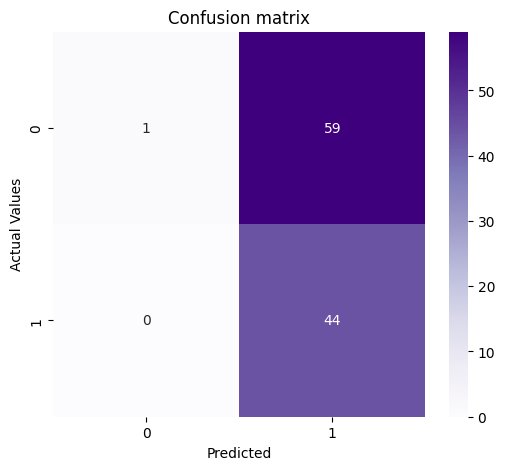

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

y_prob =  model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.4f}")

rec = recall_score(y_test, y_pred)
print(f"Recall: {rec:.4f}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

confmtrx = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(confmtrx, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Values')
plt.show()
